In [1]:
import piq

In [7]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet
from skimage.color import rgb2lab, lab2rgb

from sklearn.model_selection import train_test_split
from torchvision import transforms as T
import torch
import cv2
import os
import glob
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [3]:
body = create_body(resnet18, pretrained=True, n_in=1, cut=-2)
net_G = DynamicUnet(body, 2, (256, 256)).to('cuda')
net_G.load_state_dict(torch.load('model/color_gen.pt'))
net_G.to('cuda')
net_G.eval()

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [4]:
images = glob.glob('../data/images/Train/*.jpg')
train_images, test_images = train_test_split(images, test_size=0.2, random_state=2021)

In [5]:
scores = {
    'DISTS': []
}

for image in test_images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    lab_img = rgb2lab(img).astype(np.float32)
    lab_img = T.ToTensor()(lab_img)
    L = lab_img[[0], ...] / 50. - 1. # Between -1 and 1
    
    with torch.no_grad():
        pred_ab = net_G(L.unsqueeze(0).to('cuda'))
    
    L_true = lab_img[[0], ...]
    pred_ab = pred_ab * 110.
    Lab_pred = torch.cat([L_true, pred_ab.squeeze(0).cpu()])

    Lab_pred = Lab_pred.permute(1, 2, 0).numpy()
    rgb_pred = lab2rgb(Lab_pred)

    img_tensor = torch.tensor(img) / 255.
    img_tensor = img_tensor.permute(2, 1, 0)

    rgb_tensor = torch.tensor(rgb_pred) / 255.
    rgb_tensor = rgb_tensor.permute(2, 1, 0)

    dists_score = piq.DISTS()(img_tensor, rgb_tensor).item()
    
    scores['DISTS'].append(dists_score)

/home/superceed1/anaconda3/envs/py38torch17/lib/python3.8/site-packages/piq/perceptual.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = [torch.tensor(w) for w in weights]
/home/superceed1/anaconda3/envs/py38torch17/lib/python3.8/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/home/superceed1/anaconda3/envs/py38torch17/lib/python3.8/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 28 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/home/superceed1/anaconda3/envs/py38torch17/lib/python3.8/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/home/supercee

In [6]:
for score in scores:
    print('Score {}: {}'.format(score, np.mean(scores[score])))

Score DISTS: 0.7835666849144868


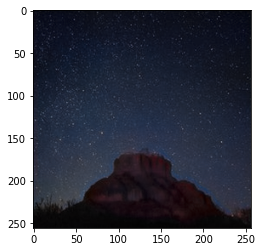

In [12]:
plt.imshow(rgb_pred)